# **Project-2: Stabilization of a Inverted pendulum on a cart using MPC controller**

Dhinakar Venkatagiri

1229296993


###**Objective Function:**
The primary goal is to design a controller that steers an inverted pendulum on a cart to an upright position and maintains it there. The system starts with the pendulum slightly tilted from the vertical position, and the objective is to find control inputs that drive both the pendulum's angle and the cart's position to zero.



---


###**State Variables:**

*   x[0]: Cart's position.
*   x[1]: Cart's velocity.
*   x[2]:  Pendulum's angle with the vertical
*   x[3]:  Pendulum's angular velocity.

### **Control Variables:**
*   u: Control force applied to the cart.



---
### **System Dynamics:**

The position of the cart (x[0]) and the angle of the pendulum (x[2]) are integrated over time using their respective velocities. Therefore, we have:
\begin{equation}
\dot{x}[0] = x[1]
\end{equation}

\begin{equation}
\dot{x}[2] = x[3]
\end{equation}

These are simple integrative relationships.

The velocity of the cart (x[1]) and the angular velocity of the pendulum (x[3]) are given by the following ODEs, which arise from the force and torque balances:
For the cart:

\begin{equation}
\dot{x}[1] = \frac{u + m \sin(x[2]) (l x[3]^2 + g \cos(x[2]))}{M + m - m \cos^2(x[2])}
\end{equation}

For the pendulum:

\begin{equation}
\dot{x}[3] = \frac{-l m x[3]^2 \sin(x[2]) \cos(x[2]) - \sin(x[2]) u - (M + m) g \sin(x[2])}{l (M + m - m \cos^2(x[2]))}
\end{equation}

So, altogether, we have these four equations capturing the system dynamics, where x[0] is the cart's position, x[1] is the cart's velocity, x[2] is the pendulum's angle, and x[3] is the pendulum's angular velocity.


Where:


- \( g \) is the gravitational acceleration

- \( M \) is the mass of the cart

- \( m \) is the mass of the pendulum
- \( l \) stands for the effective length of the pendulum


In [15]:
!pip install cvxpy==1.4.1
!pip install cvxpylayers==0.1.6

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

### **Assumptions**

- \( g \) is the gravitational acceleration, with a value of:
$$ g = 9.81 \, \text{m/s}^2 $$

- \( M \) is the mass of the cart, assigned as:
$$ M = 0.5 \, \text{kg} $$

- \( m \) is the mass of the pendulum, defined as:
$$ m = 0.2 \, \text{kg} $$

- \( l \) stands for the effective length of the pendulum, estimated to be:
$$ l = 0.3 \, \text{m} $$


#### **Solving using MPC controller**

Current State: [0. 0. 1. 0.]
Action Taken: [-0.01961639]
Current State: [ 0.          0.01359702  1.         -0.2993424 ]
Action Taken: [-0.01963433]
Current State: [ 1.3597016e-04  2.7264260e-02  9.9700660e-01 -5.9891903e-01]
Action Taken: [-0.0195937]
Current State: [ 4.0861274e-04  4.1193023e-02  9.9101740e-01 -8.9887965e-01]
Action Taken: [-0.01949486]
Current State: [ 8.2054298e-04  5.5572852e-02  9.8202860e-01 -1.1993639e+00]
Action Taken: [-0.01933815]
Current State: [ 1.3762715e-03  7.0589654e-02  9.7003496e-01 -1.5004911e+00]
Action Taken: [-0.01912389]
Current State: [ 0.00208217  0.08642352  0.95503    -1.8023484 ]
Action Taken: [-0.01885233]
Current State: [ 0.0029464   0.10324611  0.93700653 -2.1049776 ]
Action Taken: [-0.0185237]
Current State: [ 0.00397886  0.12121755  0.91595674 -2.4083602 ]
Action Taken: [-0.01813823]
Current State: [ 0.00519104  0.14048252  0.8918731  -2.712399  ]
Action Taken: [-0.01769607]
Current State: [ 0.00659586  0.1611654   0.86474913 -3.01689

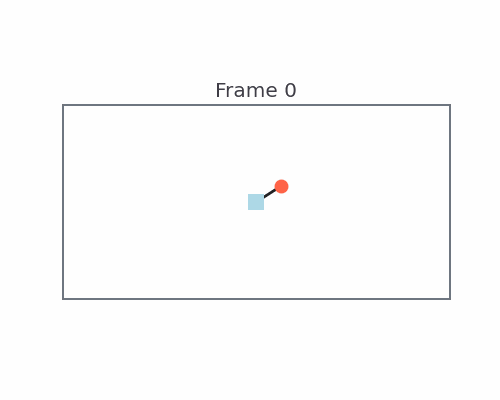

In [16]:
class Dynamics(nn.Module):
    def __init__(self, M, m, l, g=9.81):
        super(Dynamics, self).__init__()
        self.M = M
        self.m = m
        self.l = l
        self.g = g

    def forward(self, x, u):
        M, m, l, g = self.M, self.m, self.l, self.g
        s = torch.sin(x[2])
        c = torch.cos(x[2])

        dxdt = torch.zeros_like(x)
        dxdt[0] = x[1]
        dxdt[2] = x[3]

        den1 = M + m - m * c**2
        dxdt[1] = ((u + m * s * (l * x[3]**2 + g * c)) / den1)
        dxdt[3] = ((- l * m * s * x[3]**2 - s * u - (M + m) * g * s) / (l * den1))

        return x + dxdt * 0.01

# Define MPC Controller
class MPCController:
    def __init__(self, A, B, N=10, Q=None, R=None):
        self.A = A
        self.B = B
        self.N = N

        n = A.shape[0]
        m = B.shape[1]

        self.Q = Q if Q is not None else np.eye(n)
        self.R = R if R is not None else np.eye(m)

        self.x = cp.Variable((n, N+1))
        self.u = cp.Variable((m, N))

    def control(self, x0, umax=1.0):
        cost = 0
        constr = []

        for t in range(self.N):
            cost += cp.quad_form(self.x[:, t+1] - x0, self.Q)
            cost += cp.quad_form(self.u[:, t], self.R)

            constr += [self.x[:, t+1] == self.A @ self.x[:, t] + self.B @ self.u[:, t]]
            constr += [cp.norm(self.u[:, t], 'inf') <= umax]

        constr += [self.x[:, 0] == x0]
        problem = cp.Problem(cp.Minimize(cost), constr)
        problem.solve()

        if problem.status == cp.OPTIMAL:
            action = self.u.value[:, 0]
            print("Current State:", x0)
            print("Action Taken:", action)
            return action
        else:
            print("Problem not solved")
            return np.zeros((self.B.shape[1],))

# Function to perform linearization
def linearize_dynamics(M, m, l, g):
    x0 = torch.tensor([0.0, 0.0, 0.0, 0.0])
    u0 = torch.tensor(0.0)
    dynamics = Dynamics(M, m, l, g)
    dxdt0 = dynamics(x0, u0)

    delta_x = torch.tensor([1e-3, 1e-3, 1e-3, 1e-3])
    A = torch.zeros((4, 4))
    B = torch.zeros((4, 1))

    for i in range(4):
        x_perturbed = x0.clone()
        x_perturbed[i] += delta_x[i]
        dxdt_perturbed = dynamics(x_perturbed, u0)
        A[:, i] = (dxdt_perturbed - dxdt0) / delta_x[i]

    B[:, 0] = torch.tensor([0.0, 1.0 / M, 0.0, 0.0])
    return A, B

def simulate_with_mpc(dynamics, controller, x0, T):
    x = x0.unsqueeze(1)  # Reshape x0 to have 2 dimensions
    trajectory = []
    for t in range(T):
        u = controller.control(x[:, t].numpy())  # Convert to numpy array for cvxpy compatibility
        x_next = dynamics(x[:, t], torch.tensor(u, dtype=torch.float32))
        x = torch.cat((x, x_next.unsqueeze(1)), dim=1)  # Append the new state to x
        trajectory.append(x_next)
    return trajectory

M = 0.5
m = 0.2
l = 0.3
g = 9.81

A, B = linearize_dynamics(M, m, l, g)

A_np = A.numpy()
B_np = B.numpy()

# Create MPC Controller
mpc_controller = MPCController(A_np, B_np, N=10)

dynamics = Dynamics(M, m, l, g)

# Define initial state
x0 = torch.tensor([0., 0., 1., 0.])

trajectory = simulate_with_mpc(dynamics, mpc_controller, x0, T=100)


# Visualization code
def draw_cart_pendulum(t, trajectory, ax=None):
    l = 0.3  # Length of the pendulum

    # Extracting position and angle data from trajectory
    cart_x = trajectory[t][0].item()
    theta = trajectory[t][2].item()

    pendulum_x = cart_x + l * np.sin(theta)
    pendulum_y = l * np.cos(theta)

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    ax.clear()
    ax.plot([cart_x, pendulum_x], [0, pendulum_y], color="k", lw=2)
    ax.plot(cart_x, 0, 's', color='lightblue', markersize=12)
    ax.plot(pendulum_x, pendulum_y, 'o', color='tomato', markersize=10)

    # Setting limits, aspect ratio, and title
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True)
    ax.set_title(f"Frame {t}")
    return ax

fig, ax = plt.subplots(figsize=(5, 4))
ani = FuncAnimation(fig, draw_cart_pendulum, frames=len(trajectory), fargs=(trajectory, ax), interval=50, repeat=False)


# Save as a gif
writer = PillowWriter(fps=20)
ani.save("inverted_pendulum_animation_mpc.gif", writer=writer)
plt.close(fig)

display(Image(filename="inverted_pendulum_animation_mpc.gif"))



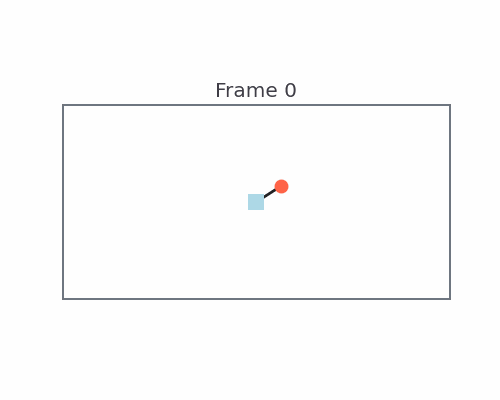